## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

For this project, I have been working to understand the results of an A/B test run by an e-commerce website.My goal is to work through this notebook to help a company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:
    

In [2]:
df =pd.read_csv('ab_data.csv')
df.head(150)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
145,857251,2017-01-14 15:28:49.816813,control,old_page,1
146,771871,2017-01-09 13:20:09.148080,control,old_page,0
147,887171,2017-01-11 14:53:00.627386,treatment,new_page,0
148,919633,2017-01-18 12:04:31.089462,treatment,new_page,0


b. Use the cell below to find the number of rows in the dataset.

In [3]:
# Find Number or colums and rows
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
#User_id as the number unique users 
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

d. The proportion of users converted.

In [5]:
#Nunmber of uses converted
(df.converted == True).sum()

35237

In [6]:
#The proportion of users converted.
df.converted.mean()

0.11965919355605512

e. The number of times the new_page and treatment don't match.

In [7]:
# Number of times that in the dataframe matches only old_page & treatment
df_t=(df.query('group == "treatment"')['landing_page'] == 'old_page').sum()
df_c=(df.query('group == "control"')['landing_page'] == 'new_page').sum()
df_t + df_c


3893

In [8]:
#Find the nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


2. For the rows where treatment does not match with new_page or control does not match with old_page, we cannot be sure if this row truly received the new or old page. Use Quiz 2 in the classroom to figure out how we should handle these rows.

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz. Store your new dataframe in df2.

In [9]:
df2 = df.query("group == 'control' and landing_page == 'old_page'")
df2 = df2.append(df.query("group == 'treatment' and landing_page == 'new_page'"))

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

3. Use df2 and the cells below to answer questions for Quiz3 in the classroom.

a. How many unique user_ids are in df2?

In [11]:
#Number of unique users_id
df2.user_id.nunique()

290584

b. There is one user_id repeated in df2. What is it?

In [12]:
# Number of duplicated rows in the dataframe with the same user_id
sum(df2.user_id.duplicated())


1

c. What is the row information for the repeat user_id?

In [13]:
# Get the duplicated row  
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove one of the rows with a duplicate user_id, but keep your dataframe as df2.

In [14]:
# Drop the duplicate row number(2893) from dataframe
df2 = df2.drop(2893)

4. Use df2 in the cells below to answer the quiz questions related to Quiz 4 in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
#By getting the mean of converted we can find the propability
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the control group, what is the probability they converted?

In [16]:
#The probability in the control group and converted is 0.1204
df2.groupby('group')['converted'].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

c. Given that an individual was in the treatment group, what is the probability they converted?

In [17]:
#The probability in the treatment group and converted is 0.1188
df2.groupby('group')['converted'].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

d. What is the probability that an individual received the new page?

In [18]:
#Count number of new_pages and old_pages and divide
#them by the total lenght of our dataframe we can get the two probabilities 
df2.landing_page.value_counts() / len(df2)


new_page    0.500062
old_page    0.499938
Name: landing_page, dtype: float64

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

The probability of an individual received the new page is slightly bigger than the old page.Ηowever, In order to get reliable results we have to implement hypothesis test and reach in accurate conclusion.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old} - p_{new} \geq 0$$


$$H_1: p_{old}- p_{new} < 0$$


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
#The probability of conversion rate for  P𝑛𝑒𝑤  under the null.
null_new = (df2.converted == 1).mean()
null_new

0.11959708724499628

b. What is the conversion rate for  𝑝𝑜𝑙𝑑  under the null?

In [20]:
#The probability of conversion rate for  Pold  under the null.
null_old = (df2.converted == 1).mean()
null_old

0.11959708724499628

c. What is  𝑛𝑛𝑒𝑤 , the number of individuals in the treatment group?

In [21]:
#The number of individuals in the treatment group
n_new = df2.groupby('group')['user_id'].count()
n_new

group
control      145274
treatment    145310
Name: user_id, dtype: int64

d. What is  𝑛𝑜𝑙𝑑 , the number of individuals in the control group?

In [22]:
# the number of individuals in the control group
n_old = df2.groupby('group')['user_id'].count()
n_old

group
control      145274
treatment    145310
Name: user_id, dtype: int64

e. Simulate  𝑛𝑛𝑒𝑤  transactions with a conversion rate of  𝑝𝑛𝑒𝑤  under the null. Store these  𝑛𝑛𝑒𝑤  1's and 0's in new_page_converted.

In [23]:
new_page_converted = np.random.binomial(n_new, null_new)


f. Simulate  𝑛𝑜𝑙𝑑  transactions with a conversion rate of  𝑝𝑜𝑙𝑑  under the null. Store these  𝑛𝑜𝑙𝑑  1's and 0's in old_page_converted.

In [24]:
old_page_converted = np.random.binomial(n_old, null_old)

g. Find  𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  for your simulated values from part (e) and (f).

In [27]:
#In order to find probabilities we have to diviate The P𝑛𝑒w -  P𝑜𝑙𝑑 
#by their invidual numbers  
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.00014473349223376175

In [28]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new, null_new)/n_new
    old_page_converted = np.random.binomial(n_old, null_old)/n_old
    p_diffs.append(new_page_converted-old_page_converted)

i. Plot a histogram of the p_diffs. Does this plot look like what you expected? Use the matching problem in the classroom to assure you fully understand what was computed here.

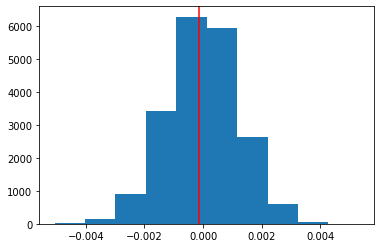

In [29]:
#Convert to array
p_diffs= np.array(p_diffs)
#Create a normal distribution centered at zero
null_vals=np.random.normal(0,p_diffs.std(),p_diffs.size)
#Observe statistic falls
plt.hist(null_vals);
plt.axvline(diff,c='red');

j. What proportion of the p_diffs are greater than the actual difference observed in ab_data.csv?

In [32]:
#Find the P-value
(null_vals > diff).mean()

0.5526

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

The given result in j question  is  statistical significant as P-value is larger than Type I error rate​ 0.5 It is seems that our statistic is from the null. So we do not reject null hypothesis,control  have higher conversion rates than the treatment : $$H_0: p_{old} - p_{new} \geq 0$$

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum() 
convert_new = df2.query('group == "treatment"')['converted'].sum() 
n_old = df2.query('landing_page == "old_page"').shape[0] 
n_new = df2.query('landing_page == "new_page"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_old, n_new], alternative="smaller")
z_score, p_value

(-1.2616957421858055, 0.1035291448032774)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

###### We could summarize that the computation of z-score and p-value verifie the conclusion in question (J). Empirically Z-Score critical value is between (-1.96 – 1.96)  furthermore P-value it seems to be close to 0.1 that means that the conversion rates of the old and new pages are not statistically different,again we fail reject the null hypothesis.
